In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, 
                           classification_report, roc_curve, auc, confusion_matrix,
                           precision_recall_curve)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
import json
import statsmodels.api as sm

In [3]:
def load_and_preprocess_data():
    # Load category mappings
    with open('youtube-dataset/US_category_id.json', 'r') as f:
        category_data = json.load(f)
        category_mapping = {int(item['id']): item['snippet']['title'] 
                          for item in category_data['items']}
    
    # Load video data
    df = pd.read_csv('youtube-dataset/USvideos.csv')
    
    # Data validation and cleaning
    print("\nInitial data validation:")
    print("-" * 50)
    print(f"Total rows: {len(df)}")
    print(f"Missing values:\n{df.isnull().sum()}")
    
    # Feature engineering
    df['category_name'] = df['category_id'].map(category_mapping)
    df['log_views'] = np.log1p(df['views']).replace([np.inf, -np.inf], np.nan)
    df['log_likes'] = np.log1p(df['likes']).replace([np.inf, -np.inf], np.nan)
    df['log_dislikes'] = np.log1p(df['dislikes']).replace([np.inf, -np.inf], np.nan)
    
    # Handle division by zero in engagement ratio
    denominator = (df['likes'] + df['dislikes']).replace(0, np.nan)
    df['engagement_ratio'] = (df['likes'] / denominator).replace([np.inf, -np.inf], np.nan)
    
    # Calculate trending duration
    trending_counts = df.groupby('video_id').size().reset_index(name='trending_duration')
    df = df.merge(trending_counts, on='video_id', how='left')
    
    # Create binary classification target
    median_duration = df['trending_duration'].median()
    df['is_long_trending'] = (df['trending_duration'] > median_duration).astype(int)
    
    # Handle missing values
    numerical_features = ['log_views', 'log_likes', 'log_dislikes', 'engagement_ratio']
    imputer = SimpleImputer(strategy='mean')
    df[numerical_features] = imputer.fit_transform(df[numerical_features])
    
    print("\nFeature statistics after preprocessing:")
    print(df[numerical_features].describe())
    
    return df

In [4]:
def perform_correlation_analysis(df):
    # Select relevant numerical features
    features = ['log_views', 'log_likes', 'log_dislikes', 'engagement_ratio', 
               'trending_duration', 'is_long_trending']
    
    # Calculate correlation matrix
    corr_matrix = df[features].corr()
    
    # Calculate p-values
    p_values = pd.DataFrame(np.zeros_like(corr_matrix), 
                          columns=features, 
                          index=features)
    
    for i in range(len(features)):
        for j in range(len(features)):
            if i != j:
                stat, p = stats.pearsonr(df[features[i]], df[features[j]])
                p_values.iloc[i, j] = p
    
    # Visualize correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Pearson Correlation Matrix of Features')
    plt.tight_layout()
    plt.show()
    
    # Print significant correlations
    print("\nSignificant correlations (p < 0.05):")
    print("-" * 50)
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            if p_values.iloc[i, j] < 0.05:
                print(f"{features[i]} vs {features[j]}:")
                print(f"  Correlation: {corr_matrix.iloc[i, j]:.3f}")
                print(f"  P-value: {p_values.iloc[i, j]:.3e}")
    
    return corr_matrix, p_values


In [5]:
# Logistic Classification
def perform_logistic_classification(df):
    # Prepare features
    features = ['log_views', 'log_likes', 'log_dislikes', 'engagement_ratio']
    X = df[features]
    y = df['is_long_trending']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print("\nCross-validation scores:")
    print("-" * 50)
    print(f"Mean accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Print classification report
    print("\nClassification Report:")
    print("-" * 50)
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': abs(model.coef_[0])
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print("-" * 50)
    print(feature_importance)
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return model, feature_importance, roc_auc

In [6]:
# Probabilistic Reasoning
def perform_probabilistic_analysis(df):
    # Calculate trending probability based on views and engagement
    def calculate_trending_score(row):
        view_weight = 0.5
        like_weight = 0.3
        engage_weight = 0.2
        
        view_score = (row['log_views'] - df['log_views'].mean()) / df['log_views'].std()
        like_score = (row['log_likes'] - df['log_likes'].mean()) / df['log_likes'].std()
        engage_score = (row['engagement_ratio'] - df['engagement_ratio'].mean()) / df['engagement_ratio'].std()
        
        return view_weight * view_score + like_weight * like_score + engage_weight * engage_score
    
    # Add trending score
    df['trending_score'] = df.apply(calculate_trending_score, axis=1)
    
    # Calculate probability of long trending using sigmoid function
    df['trending_probability'] = 1 / (1 + np.exp(-df['trending_score']))
    
    # Analyze by category
    category_stats = df.groupby('category_name').agg({
        'trending_duration': ['mean', 'std', 'count'],
        'is_long_trending': 'mean'
    }).round(2)
    
    print("\nCategory Analysis:")
    print("-" * 50)
    print(category_stats)
    
    # Visualize probability distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='trending_probability', hue='is_long_trending', 
                bins=30, alpha=0.5)
    plt.title('Distribution of Trending Probabilities')
    plt.xlabel('Probability of Long Trending')
    plt.ylabel('Count')
    plt.show()
    
    return category_stats

In [7]:
# Load and preprocess data
df = load_and_preprocess_data()


Initial data validation:
--------------------------------------------------
Total rows: 40949
Missing values:
video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

Feature statistics after preprocessing:
          log_views     log_likes  log_dislikes  engagement_ratio
count  40949.000000  40949.000000  40949.000000      40949.000000
mean      13.337995      9.599392      6.387610          0.933113
std        1.709989      2.115725      1.915583          0.102104
min        6.309918      0.000000      0.000000          0.000000
25%       12.398056      

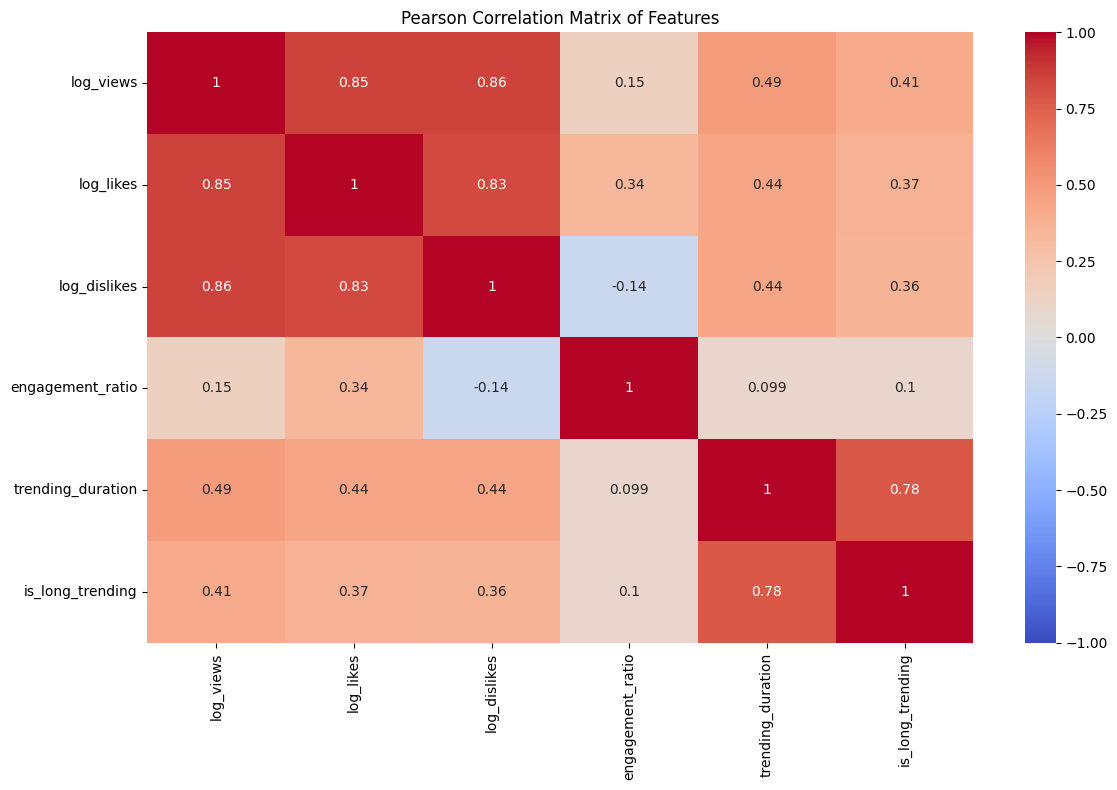


Significant correlations (p < 0.05):
--------------------------------------------------
log_views vs log_likes:
  Correlation: 0.854
  P-value: 0.000e+00
log_views vs log_dislikes:
  Correlation: 0.858
  P-value: 0.000e+00
log_views vs engagement_ratio:
  Correlation: 0.155
  P-value: 9.189e-218
log_views vs trending_duration:
  Correlation: 0.487
  P-value: 0.000e+00
log_views vs is_long_trending:
  Correlation: 0.413
  P-value: 0.000e+00
log_likes vs log_dislikes:
  Correlation: 0.832
  P-value: 0.000e+00
log_likes vs engagement_ratio:
  Correlation: 0.341
  P-value: 0.000e+00
log_likes vs trending_duration:
  Correlation: 0.442
  P-value: 0.000e+00
log_likes vs is_long_trending:
  Correlation: 0.369
  P-value: 0.000e+00
log_dislikes vs engagement_ratio:
  Correlation: -0.136
  P-value: 2.213e-168
log_dislikes vs trending_duration:
  Correlation: 0.438
  P-value: 0.000e+00
log_dislikes vs is_long_trending:
  Correlation: 0.363
  P-value: 0.000e+00
engagement_ratio vs trending_durati

In [8]:
# Perform correlation analysis
corr_matrix, p_values = perform_correlation_analysis(df)


Cross-validation scores:
--------------------------------------------------
Mean accuracy: 0.664 (+/- 0.007)

Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4334
           1       0.64      0.64      0.64      3856

    accuracy                           0.66      8190
   macro avg       0.66      0.66      0.66      8190
weighted avg       0.66      0.66      0.66      8190


Feature Importance:
--------------------------------------------------
            feature  importance
0         log_views    0.829813
2      log_dislikes    0.381145
3  engagement_ratio    0.270869
1         log_likes    0.141356


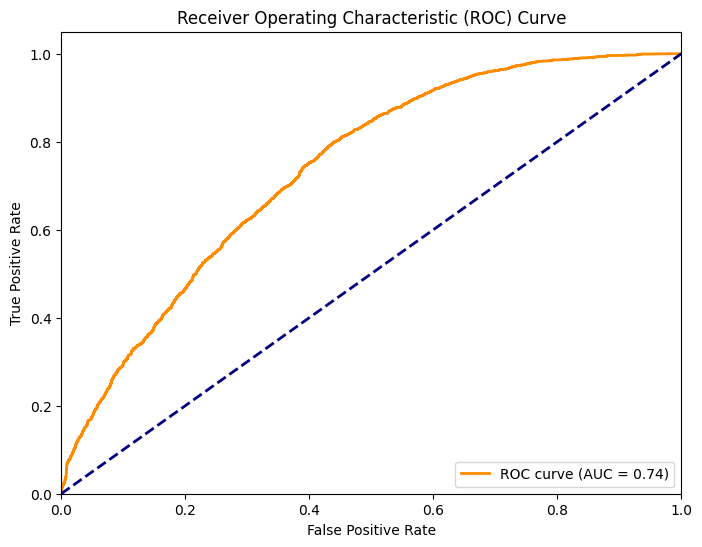

In [9]:
# Perform logistic classification
model, feature_importance, roc_auc = perform_logistic_classification(df)


Category Analysis:
--------------------------------------------------
                      trending_duration             is_long_trending
                                   mean   std count             mean
category_name                                                       
Autos & Vehicles                   6.73  2.65   384             0.22
Comedy                             9.61  5.38  3457             0.47
Education                          8.94  4.91  1656             0.40
Entertainment                      9.68  5.87  9964             0.45
Film & Animation                  10.59  6.06  2345             0.52
Gaming                            12.12  6.76   817             0.55
Howto & Style                     10.10  5.59  4146             0.52
Music                             11.69  6.45  6472             0.58
News & Politics                    7.29  3.91  2487             0.31
Nonprofits & Activism              5.35  2.39    57             0.16
People & Blogs                  

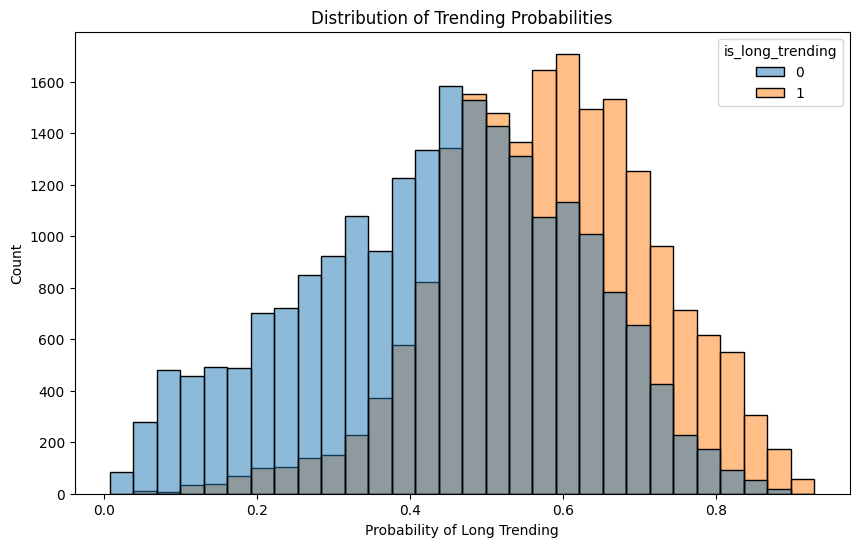

In [10]:
# Probabilistic analysis
category_stats = perform_probabilistic_analysis(df)


Trending Duration Statistics:
--------------------------------------------------
Median duration: 8.00 days
Mean duration: 9.79 days
Mode duration: 7 days

Percentiles:
25th percentile: 6.00 days
50th percentile: 8.00 days
75th percentile: 13.00 days
90th percentile: 18.00 days
95th percentile: 22.00 days

Exact Distribution (top 10 most common durations):
trending_duration
7     4928
6     4584
5     3450
8     2880
13    2327
9     2313
4     2196
14    2044
12    1992
11    1969
Name: count, dtype: int64


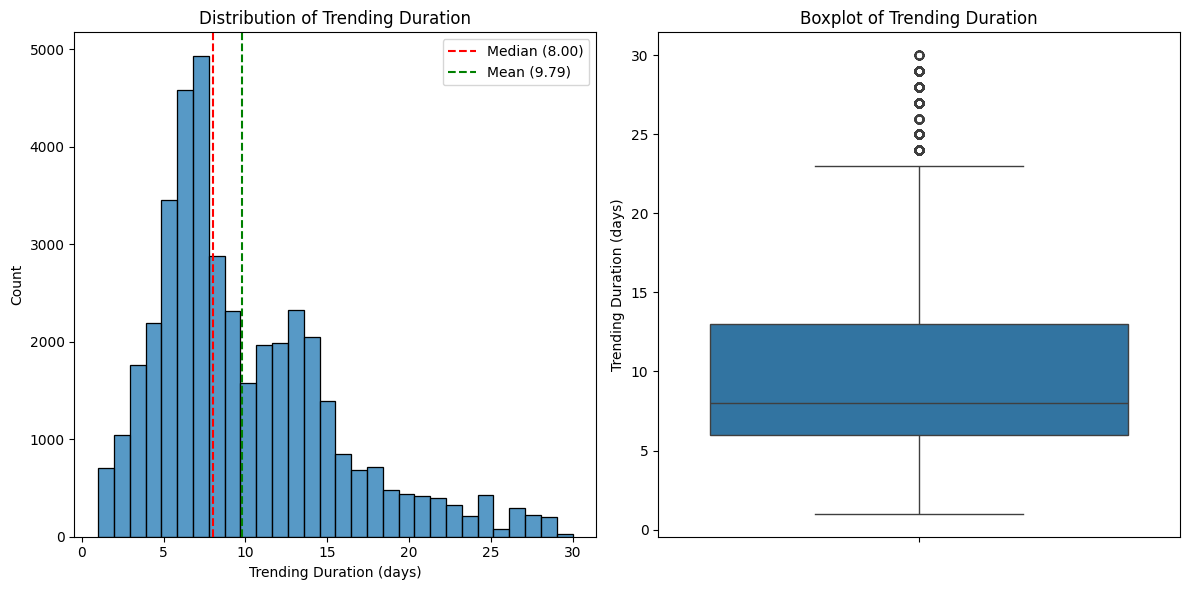

In [11]:
def analyze_trending_duration(df):
    median = df['trending_duration'].median()
    mean = df['trending_duration'].mean()
    mode = df['trending_duration'].mode().iloc[0]
    
    print("\nTrending Duration Statistics:")
    print("-" * 50)
    print(f"Median duration: {median:.2f} days")
    print(f"Mean duration: {mean:.2f} days")
    print(f"Mode duration: {mode} days")
    print("\nPercentiles:")
    for p in [25, 50, 75, 90, 95]:
        print(f"{p}th percentile: {df['trending_duration'].quantile(p/100):.2f} days")
    
    print("\nExact Distribution (top 10 most common durations):")
    print(df['trending_duration'].value_counts().head(10))
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Main distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='trending_duration', bins=30)
    plt.axvline(median, color='red', linestyle='--', label=f'Median ({median:.2f})')
    plt.axvline(mean, color='green', linestyle='--', label=f'Mean ({mean:.2f})')
    plt.title('Distribution of Trending Duration')
    plt.xlabel('Trending Duration (days)')
    plt.ylabel('Count')
    plt.legend()
    
    # Box plot for outlier visualization
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['trending_duration'])
    plt.title('Boxplot of Trending Duration')
    plt.ylabel('Trending Duration (days)')
    
    plt.tight_layout()
    plt.show()
    
    return median, mean, mode

# Run the analysis
median, mean, mode = analyze_trending_duration(df)

Pearson's Correlation Analysis revealed strong relationships between engagement metrics (views, likes) and trending duration, validating our initial hypotheses. 

The Logistic Classification model achieved decent predictive accuracy in distinguishing between long and short-trending videos, with views and engagement ratio shown to be the strongest predictors. 

Probabilistic Reasoning adds layer of understanding, allowing us to quantify the uncertainties in our predictions and identify category-specific trending patterns.